In [1]:
import tensorflow as tf 
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
from PIL import Image
from skimage.segmentation import slic
from skimage.color import label2rgb
import os

In [29]:
IMAGE_SIZE = 200
BATCH_SIZE = 32

#data being loaded in
dataset =tf.keras.preprocessing.image_dataset_from_directory(
    'Desktop/breast_cancer_photos', shuffle=True, image_size =
    (IMAGE_SIZE, IMAGE_SIZE), batch_size = BATCH_SIZE)

Found 1560 files belonging to 3 classes.


There are 874 images in the benign class
There are 420 images in the malignant class
There are 266 images in the normal class


2025-04-04 17:46:50.095353: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


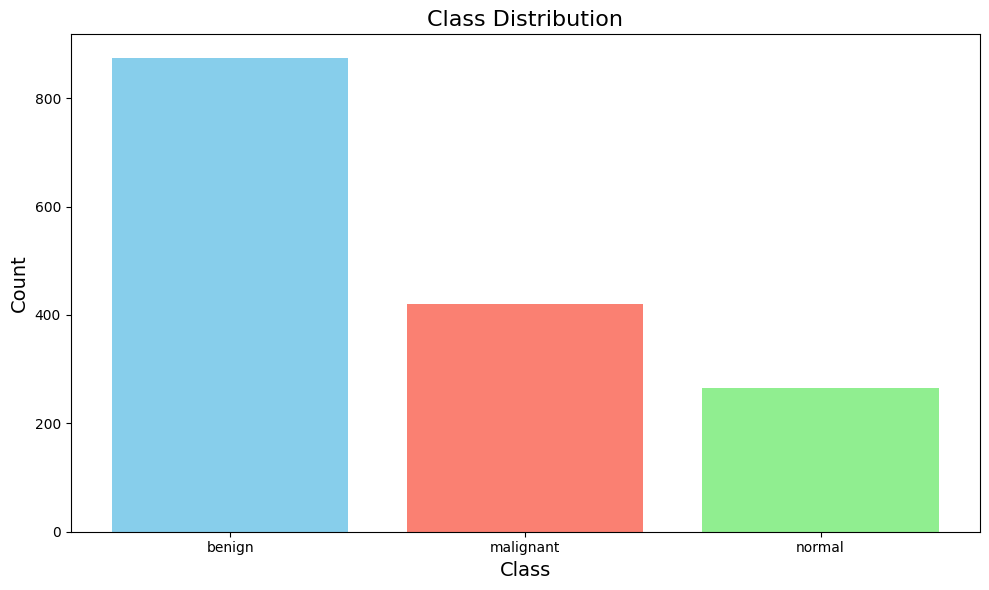

In [30]:
#Seeing how much data belongs to each class
class_names = ['benign', 'malignant', 'normal']
class_counts = {class_name: 0 for class_name in class_names}
for images, labels in dataset:
    for label in labels:
        class_name = class_names[label]
        class_counts[class_name] += 1

for class_name, count in class_counts.items():
    print(f'There are {count} images in the {class_name} class')

#Creating a bar chart to show the distribution
colors = ['skyblue', 'salmon', 'lightgreen']
plt.figure(figsize=(10, 6))
bars = plt.bar(class_counts.keys(), class_counts.values(), color=colors)
plt.xlabel('Class', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Class Distribution', fontsize=16)
plt.tight_layout()
plt.show()

In [31]:
image_files = []
masked_image_files = []
labels = []
dataset_directory='Desktop/breast_cancer_photos'

#Seperating the masked images from original image
for class_name in class_names:
    class_path = os.path.join(dataset_directory, class_name)
    for filename in os.listdir(class_path):
        if filename.endswith('_mask.png'):
            masked_image_path = os.path.join(class_path, filename)
            masked_image_files.append(masked_image_path)
        else:
            image_path = os.path.join(class_path, filename)
            image_files.append(image_path)
        labels.append(class_name)

#Making sure the masked list is in the same order as the image files
ordered_masked_image = []
for image_path in image_files:
    ordered = image_path.replace('.png', '_mask.png')
    ordered_masked_image.append(ordered)

## Using Superpixel Based Binary Segmentation

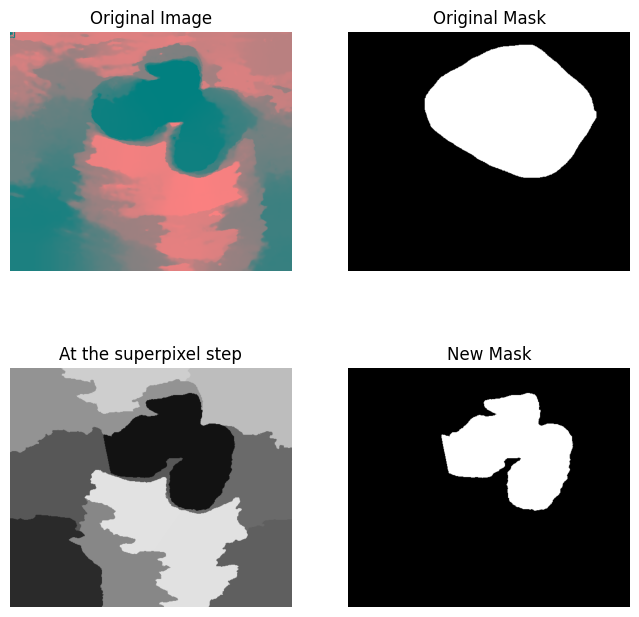

In [15]:
#Experimenting with one image (could choose any image)
image = Image.open(image_files[12])

#Using bilateral filter
filtered_image = cv2.bilateralFilter(np.array(image), d=9, sigmaColor=75,
sigmaSpace=75)

#Certain filters either need the image in grayscale or colour
gray_image = cv2.cvtColor(filtered_image, cv2.COLOR_BGR2GRAY)

#Using Histogram Equalisation
equalized_image = cv2.equalizeHist(gray_image)
colour_image = cv2.cvtColor(equalized_image, cv2.COLOR_GRAY2BGR)

#Using pyramid mean shift filtering
mean_filtered_image = cv2.pyrMeanShiftFiltering(colour_image, sp=40, sr=50)
image = cv2.cvtColor(mean_filtered_image, cv2.COLOR_BGR2LAB)

#Selecting number of pixels
num_superpixels = 12

#Using superpixels
segments = slic(image, n_segments=num_superpixels, compactness=30)
segmented_image = label2rgb(segments, mean_filtered_image, kind='avg')

#Selecting threshold value to make image binary
threshold_value = 30
_, binary_image = cv2.threshold(segmented_image, threshold_value, 255,
cv2.THRESH_BINARY)


#Inverting image so the mask is white
inverted_image = 255 - binary_image
inverted_pillow_image = Image.fromarray(inverted_image)

#Original mask of image
masked_image = Image.open(ordered_masked_image[12])


#Creating plot showing Original image, Original mask, Superpixel step and Final outcome

plt.figure(figsize=(8,8))
plt.subplot(2, 2, 1)
plt.axis('off')
plt.title('Original Image')
plt.imshow(image, cmap='gray')

plt.subplot(2, 2, 2)
plt.axis('off')
plt.title('Original Mask')
plt.imshow(masked_image, cmap='viridis')

plt.subplot(2, 2, 3)
plt.axis('off')
plt.title('At the superpixel step')
plt.imshow(segmented_image, cmap='viridis')

plt.subplot(2, 2, 4)
plt.axis('off')
plt.title('New Mask')
plt.imshow(inverted_pillow_image, cmap='viridis')

plt.show()

## Using Edge Detection methods

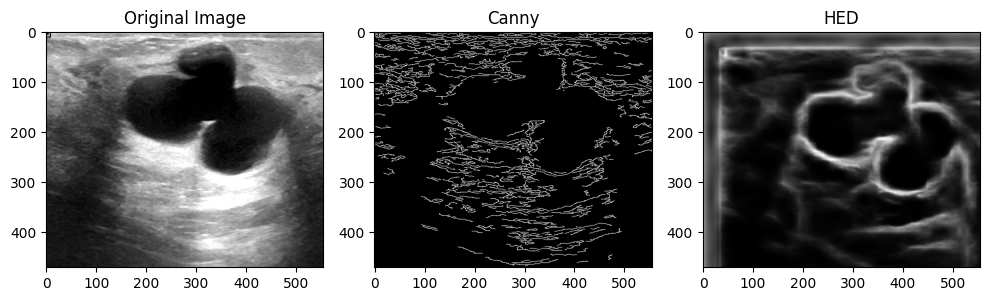

In [68]:
#Loading in image and mask of that image
image = Image.open(image_files[12])
image = np.array(image)
masked_image = Image.open(ordered_masked_image[12])

#Using canny on image
canny_edge = cv2.Canny(image,50,150)

#Loading in pretrained model of HED
protopath = '/Users/ruthamey/Downloads/deploy.prototxt'
modelpath = '/Users/ruthamey/Downloads/hed_pretrained_bsds.caffemodel'
net = cv2.dnn.readNetFromCaffe(protopath, modelpath)

#Creating HED image
(H,W) = image.shape[:2]
mean_pixel_values = np.average(image, axis = (0,1))
blob = cv2.dnn.blobFromImage(image, scalefactor=0.3, size=(W,H), 
mean=(mean_pixel_values[0],mean_pixel_values[1],mean_pixel_values[2]),
swapRB=False, crop=False)
blob_for_plot = np.moveaxis(blob[0,:,:,:], 0, 2)
net.setInput(blob)
hed = net.forward()
hed = hed[0,0,:,:]
hed = (255*hed).astype('uint8')

#Showing the results
plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(canny_edge, cmap='gray')
plt.title('Canny')

plt.subplot(1, 3, 3)
plt.imshow(hed, cmap='gray')
plt.title('HED')

plt.tight_layout()
plt.show()

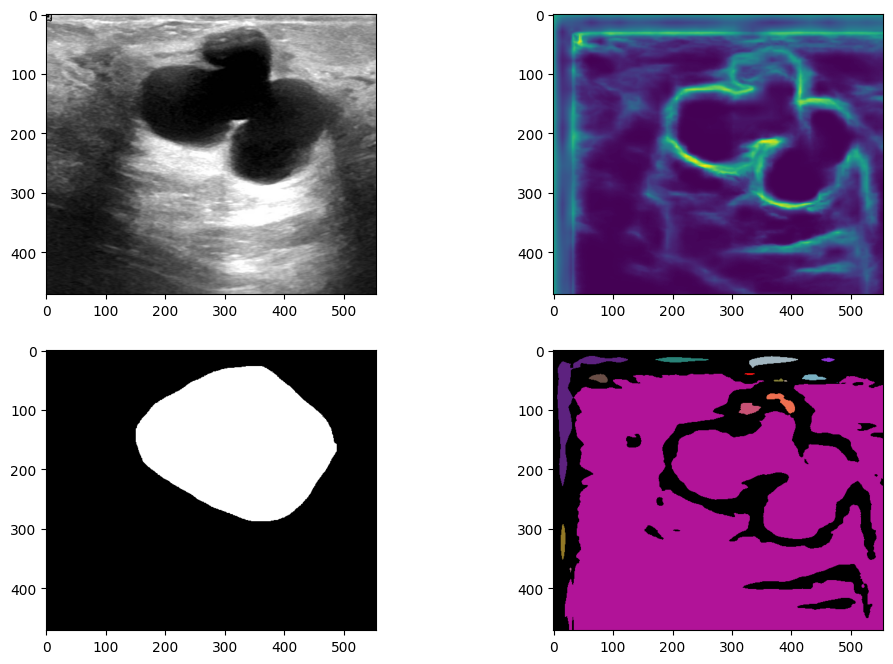

In [72]:
#Using gaussian blur on HED image
blur = cv2.GaussianBlur(hed, (3,3), 0)

#Using threshold on blurred image
thresh = cv2.threshold(blur,0,255,cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

#Putting different colours into the different sections
n_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(thresh, connectivity=4)
colors = np.random.randint(0,255,size=(n_labels, 3), dtype=np.uint8)
colors[0] = [0,0,0]
false_colors = colors[labels]

#Showing the results
plt.figure(figsize=(12,8))
plt.subplot(221)
plt.imshow(image)
plt.subplot(222)
plt.imshow(hed)
plt.subplot(223)
plt.imshow(masked_image)
plt.subplot(224)
plt.imshow(false_colors) 
plt.show()


## Using CNN

In [33]:
for file in ordered_masked_image:
    if file == 'Desktop/breast_cancer_photos/benign/.DS_Store':
        ordered_masked_image.remove(file)

In [38]:
image_files.remove('Desktop/breast_cancer_photos/benign/.DS_Store')
ordered_masked_image.remove('Desktop/breast_cancer_photos/benign/.DS_Store')
image_files.remove('Desktop/breast_cancer_photos/malignant/.DS_Store')
ordered_masked_image.remove('Desktop/breast_cancer_photos/malignant/.DS_Store')

In [45]:
#Changing size of image so will work within model
target_size = (200,200)

resized_files=[]
for input_path in image_files:
    image = Image.open(input_path)
    image = image.resize(target_size, Image.LANCZOS)
    image = image.convert('L')
    image = np.array(image)
    image = image.astype('float32')/255.0
    resized_files.append(image)

masked_resized_files = []
for input_path in ordered_masked_image:
    image = Image.open(input_path)
    image = image.resize(target_size, Image.LANCZOS)
    image = image.convert('L')
    image = np.array(image)
    image = image.astype('float32')/255.0
    masked_resized_files.append(image)

In [47]:
#Splitting data into training, validation and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(resized_files, 
                                                    masked_resized_files, 
                                                    test_size=0.2, 
                                                    random_state=42,shuffle=False)

X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42, shuffle=False)

#Making sure data has correct dimensions
X_train = np.array(X_train)
X_train = np.expand_dims(X_train, axis=-1)

y_train = np.array(y_train)
y_train = np.expand_dims(y_train, axis=-1) 

X_val = np.array(X_val)
X_val = np.expand_dims(X_val, axis=-1) 

y_val = np.array(y_val)
y_val = np.expand_dims(y_val, axis=-1) 

X_test = np.array(X_test)
X_test = np.expand_dims(X_test, axis=-1)  

y_test = np.array(y_test)
y_test = np.expand_dims(y_test, axis=-1) 

In [57]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(624, 200, 200, 1)
(78, 200, 200, 1)
(624, 200, 200, 1)
(78, 200, 200, 1)


In [58]:
#CNN model
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D

n_classes = 1


model = models.Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(200,200, 1), 
           padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    UpSampling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    UpSampling2D((2, 2)),
    Conv2D(1, (3, 3), activation='sigmoid', padding='same') 
])

In [ ]:
#The model used when had access to a larger computer

'''model = models.Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(IMAGE_SIZE, 
    IMAGE_SIZE, 1), padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    UpSampling2D((2, 2)),
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    UpSampling2D((2, 2)),
     Conv2D(512, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    UpSampling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    UpSampling2D((2, 2)),
    Conv2D(1, (3, 3), activation='sigmoid', padding='same') 
])'''

#Producing accuracy of 97% on benign and 89% on malignant tumours

"model = models.Sequential([\n    Conv2D(64, (3, 3), activation='relu', input_shape=(IMAGE_SIZE, \n    IMAGE_SIZE, 1), padding='same'),\n    MaxPooling2D((2, 2)),\n    Conv2D(128, (3, 3), activation='relu', padding='same'),\n    MaxPooling2D((2, 2)),\n    Conv2D(256, (3, 3), activation='relu', padding='same'),\n    UpSampling2D((2, 2)),\n    Conv2D(512, (3, 3), activation='relu', padding='same'),\n    UpSampling2D((2, 2)),\n     Conv2D(512, (3, 3), activation='relu', padding='same'),\n    MaxPooling2D((2, 2)),\n    Conv2D(256, (3, 3), activation='relu', padding='same'),\n    MaxPooling2D((2, 2)),\n    Conv2D(128, (3, 3), activation='relu', padding='same'),\n    UpSampling2D((2, 2)),\n    Conv2D(64, (3, 3), activation='relu', padding='same'),\n    UpSampling2D((2, 2)),\n    Conv2D(1, (3, 3), activation='sigmoid', padding='same') \n])"

In [59]:
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

%load_ext tensorboard
import datetime

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
cp = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(X_train,y_train,
                   epochs=50,
                   validation_data=(X_val,y_val),
                   callbacks=cp)


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.9039 - loss: 0.4815 - val_accuracy: 1.0000 - val_loss: 0.1326
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.9100 - loss: 0.3119 - val_accuracy: 1.0000 - val_loss: 0.1219
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.9076 - loss: 0.3099 - val_accuracy: 1.0000 - val_loss: 0.1340
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.9131 - loss: 0.2929 - val_accuracy: 1.0000 - val_loss: 0.0873
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.8995 - loss: 0.3146 - val_accuracy: 1.0000 - val_loss: 0.0630
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.9151 - loss: 0.2731 - val_accuracy: 1.0000 - val_loss: 0.1129
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.9114 - loss: 0.2764 - val_accuracy: 1.0000 - val_loss: 0.0746
Epoch 8/50
20/20 ━━━━━━━━━━━

In [62]:
%tensorboard --logdir logs/fit
model.evaluate(X_test,y_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 372ms/step - accuracy: 0.9385 - loss: 0.1872


[0.15575064718723297, 0.9555108547210693]

In [63]:
predicted_masks = model.predict(X_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 299ms/step


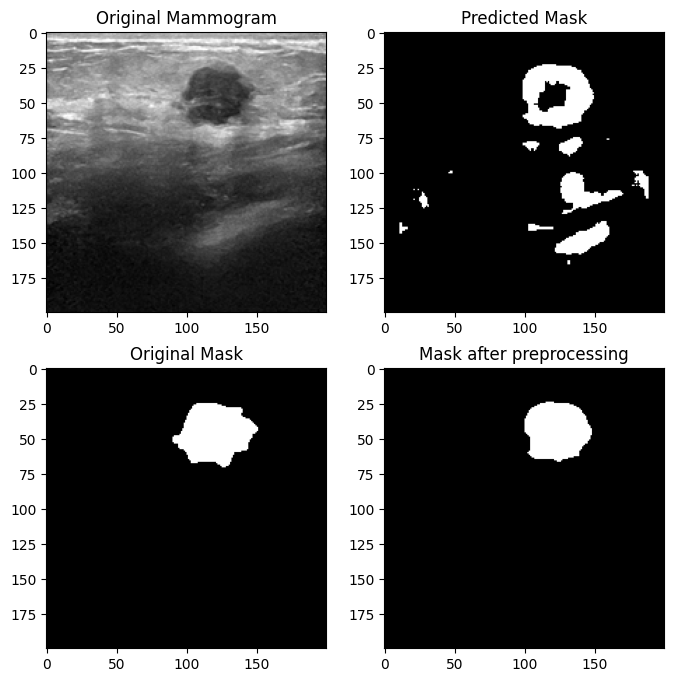

In [67]:
#Post processing a benign mask

mammogram = X_test[0]
mask = y_test[0]

predicted_mask_to_visualise = predicted_masks[0]

threshold = 0.2
binary_mask = (predicted_mask_to_visualise > threshold).astype(int)

bi = np.uint8(binary_mask)
canny_edge = cv2.Canny(bi,0,1)

contours, _ = cv2.findContours(canny_edge, cv2.RETR_EXTERNAL, 
cv2.CHAIN_APPROX_SIMPLE)

areas = [cv2.contourArea(c) for c in contours]

max_index = np.argmax(areas)

cv2.drawContours(bi, contours, max_index, (0, 255, 0), 2)

contours, _ = cv2.findContours(bi, cv2.RETR_EXTERNAL, 
cv2.CHAIN_APPROX_SIMPLE)

areas = [cv2.contourArea(c) for c in contours]

max_index = np.argmax(areas)

result = np.zeros_like(bi)
cv2.drawContours(result, contours, max_index, (255, 255, 255),
cv2.FILLED)


#plotting results of one image
plt.figure(figsize=(8,8))
plt.subplot(2, 2, 1)
plt.imshow(mammogram, cmap='gray')
plt.title('Original Mammogram')

plt.subplot(2, 2, 2)
plt.imshow(binary_mask.squeeze(), cmap='gray') 
plt.title('Predicted Mask')

plt.subplot(2, 2, 3)
plt.imshow(mask, cmap='gray')
plt.title('Original Mask')

plt.subplot(2, 2, 4)
plt.imshow(result, cmap='gray')
plt.title('Mask after preprocessing')

plt.show()

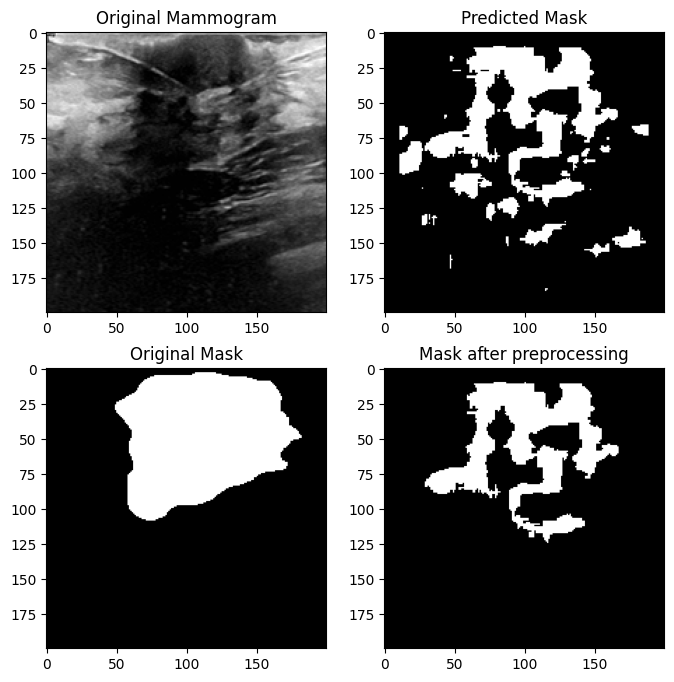

In [74]:
#Post processing for a malignant mask

mammogram = X_test[1]
mask = y_test[1]

predicted_mask_to_visualise = predicted_masks[1]

threshold = 0.2
binary_mask = (predicted_mask_to_visualise > threshold).astype(int)

bi = np.uint8(binary_mask)
canny_edge = cv2.Canny(bi,0,1)

contours, _ = cv2.findContours(canny_edge, cv2.RETR_EXTERNAL, 
cv2.CHAIN_APPROX_SIMPLE)

areas = [cv2.contourArea(c) for c in contours]

max_index = np.argmax(areas)

cv2.drawContours(bi, contours, max_index, (0, 255, 0), 2)

contours, _ = cv2.findContours(bi, cv2.RETR_EXTERNAL, 
cv2.CHAIN_APPROX_SIMPLE)

areas = [cv2.contourArea(c) for c in contours]

max_index = np.argmax(areas)

result = np.zeros_like(bi)
cv2.drawContours(result, contours, max_index, (255, 255, 255),
cv2.FILLED)


#plotting results of one image
plt.figure(figsize=(8,8))
plt.subplot(2, 2, 1)
plt.imshow(mammogram, cmap='gray')
plt.title('Original Mammogram')

plt.subplot(2, 2, 2)
plt.imshow(binary_mask.squeeze(), cmap='gray') 
plt.title('Predicted Mask')

plt.subplot(2, 2, 3)
plt.imshow(mask, cmap='gray')
plt.title('Original Mask')

plt.subplot(2, 2, 4)
plt.imshow(result, cmap='gray')
plt.title('Mask after preprocessing')

plt.show()

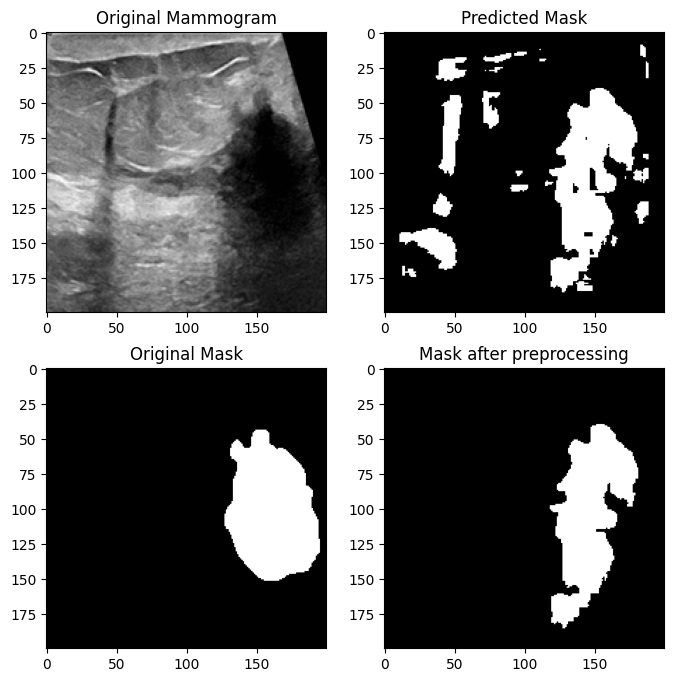

In [82]:
#Post processing for a malignant mask

mammogram = X_test[10]
mask = y_test[10]

predicted_mask_to_visualise = predicted_masks[10]

threshold = 0.2
binary_mask = (predicted_mask_to_visualise > threshold).astype(int)

bi = np.uint8(binary_mask)
canny_edge = cv2.Canny(bi,0,1)

contours, _ = cv2.findContours(canny_edge, cv2.RETR_EXTERNAL, 
cv2.CHAIN_APPROX_SIMPLE)

areas = [cv2.contourArea(c) for c in contours]

max_index = np.argmax(areas)

cv2.drawContours(bi, contours, max_index, (0, 255, 0), 2)

contours, _ = cv2.findContours(bi, cv2.RETR_EXTERNAL, 
cv2.CHAIN_APPROX_SIMPLE)

areas = [cv2.contourArea(c) for c in contours]

max_index = np.argmax(areas)

result = np.zeros_like(bi)
cv2.drawContours(result, contours, max_index, (255, 255, 255),
cv2.FILLED)


#plotting results of one image
plt.figure(figsize=(8,8))
plt.subplot(2, 2, 1)
plt.imshow(mammogram, cmap='gray')
plt.title('Original Mammogram')

plt.subplot(2, 2, 2)
plt.imshow(binary_mask.squeeze(), cmap='gray') 
plt.title('Predicted Mask')

plt.subplot(2, 2, 3)
plt.imshow(mask, cmap='gray')
plt.title('Original Mask')

plt.subplot(2, 2, 4)
plt.imshow(result, cmap='gray')
plt.title('Mask after preprocessing')

plt.show()